# **M** - _Mission_

Perform data analysis to uncover valuable insights from our comprehensive sales dataset, encompassing products purchased, transaction dates, costs, and purchase addresses from every month. By thoroughly inspecting the data, cleaning and transforming it, and employing advanced analytical techniques, we aim to identify key trends, customer behavior patterns, and geographical preferences to optimize marketing strategies, enhance operational efficiency, and drive business growth.

# **A** - _Acquire The Data_

#### Import necessary libraries

In [2]:

import os as os
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt


#### Merge data from each month into one CSV

In [4]:
# Assuming you have a directory of sales data CSV files separated by month

files = os.listdir("sales_data")

all_data = pd.DataFrame()

columns = ['Order ID', 'Product', 'Quantity Ordered', 'Price Each',	'Order Date', 'Purchase Address']

# Concat each csv together, ignoring header rows
# By not using skiprows=1 param, it converts the header row with column names as data records.
for file in files:
    data = pd.read_csv("sales_data"+"/"+file, header=None, skiprows=1)
    all_data = pd.concat([all_data, data])

all_data.to_csv("all_data.csv", index=False)
    

#### Read in updated dataframe

In [35]:
all_data = pd.read_csv("all_data.csv")

In [36]:
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


In [37]:
all_data.iloc[518:521]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
518,177054,Apple Airpods Headphones,1,150,04/09/19 19:18,"800 Jackson St, Atlanta, GA 30301"
519,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
520,177055,Lightning Charging Cable,1,14.95,04/09/19 12:37,"59 Forest St, Atlanta, GA 30301"


It appears that when the individual monthly sets were created, they already included header names mixed in \
We can clean this up later.

# **G** - _Get it Into Shape_

Preprocess and clean the acquired data to make it suitable for analysis. Handle missing values, outliers, data types, and perform necessary transformations. Often, this step will requrie some level of data exploration to learn about datatypes and statistics.

## Steps to in this process can include:

##### Data Cleaning & Formatting

1. **Handling missing values**: Identifying and dealing with missing data by imputation or removal.
2. **Handling duplicate record**s: Detecting and removing duplicate entries from the dataset.
3. **Data formatting**: Ensuring data types are appropriate for analysis, converting strings to numbers, etc.


## Handling missing values

Sorting can be a quick way of finding unexpected data, especially non-numeric values when expecting numeric, and vice versa

In [38]:
all_data.sort_values("Order ID", ascending=False)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
114812,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
85977,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
89307,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
89259,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
87579,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
...,...,...,...,...,...,...
185176,NaN,NaN,NaN,NaN,NaN,NaN
185438,NaN,NaN,NaN,NaN,NaN,NaN
186042,NaN,NaN,NaN,NaN,NaN,NaN
186548,NaN,NaN,NaN,NaN,NaN,NaN


We can easily see from using a simple sort that there are many rows not containing a valid **Order ID** value. \
In this case, there are rows containing the headers, and others with NaN values across the board.

Let's get some summary information of data types and data counts

In [39]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186850 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 8.6+ MB


Two important things to note from the above info:
1. The number of row entries is greater than the number of Non-Null values, meaning there are entire rows missing from the dataset
2. Every attribute is the same **Dtype**: _object_, even the 'Price Each' column which will certainly need to be handled as an integer later on.

### Get insights on missing data

In [40]:
# find number of NaN
all_data.isna().sum()

Order ID            545
Product             545
Quantity Ordered    545
Price Each          545
Order Date          545
Purchase Address    545
dtype: int64

We can see that there are 545 values missing from each column, indicating 545 rows entirely

We can proceed with creating a **matrix** and a **heatmap** to gain insights into the missing values, for example, if any patterns emerge.

<Axes: >

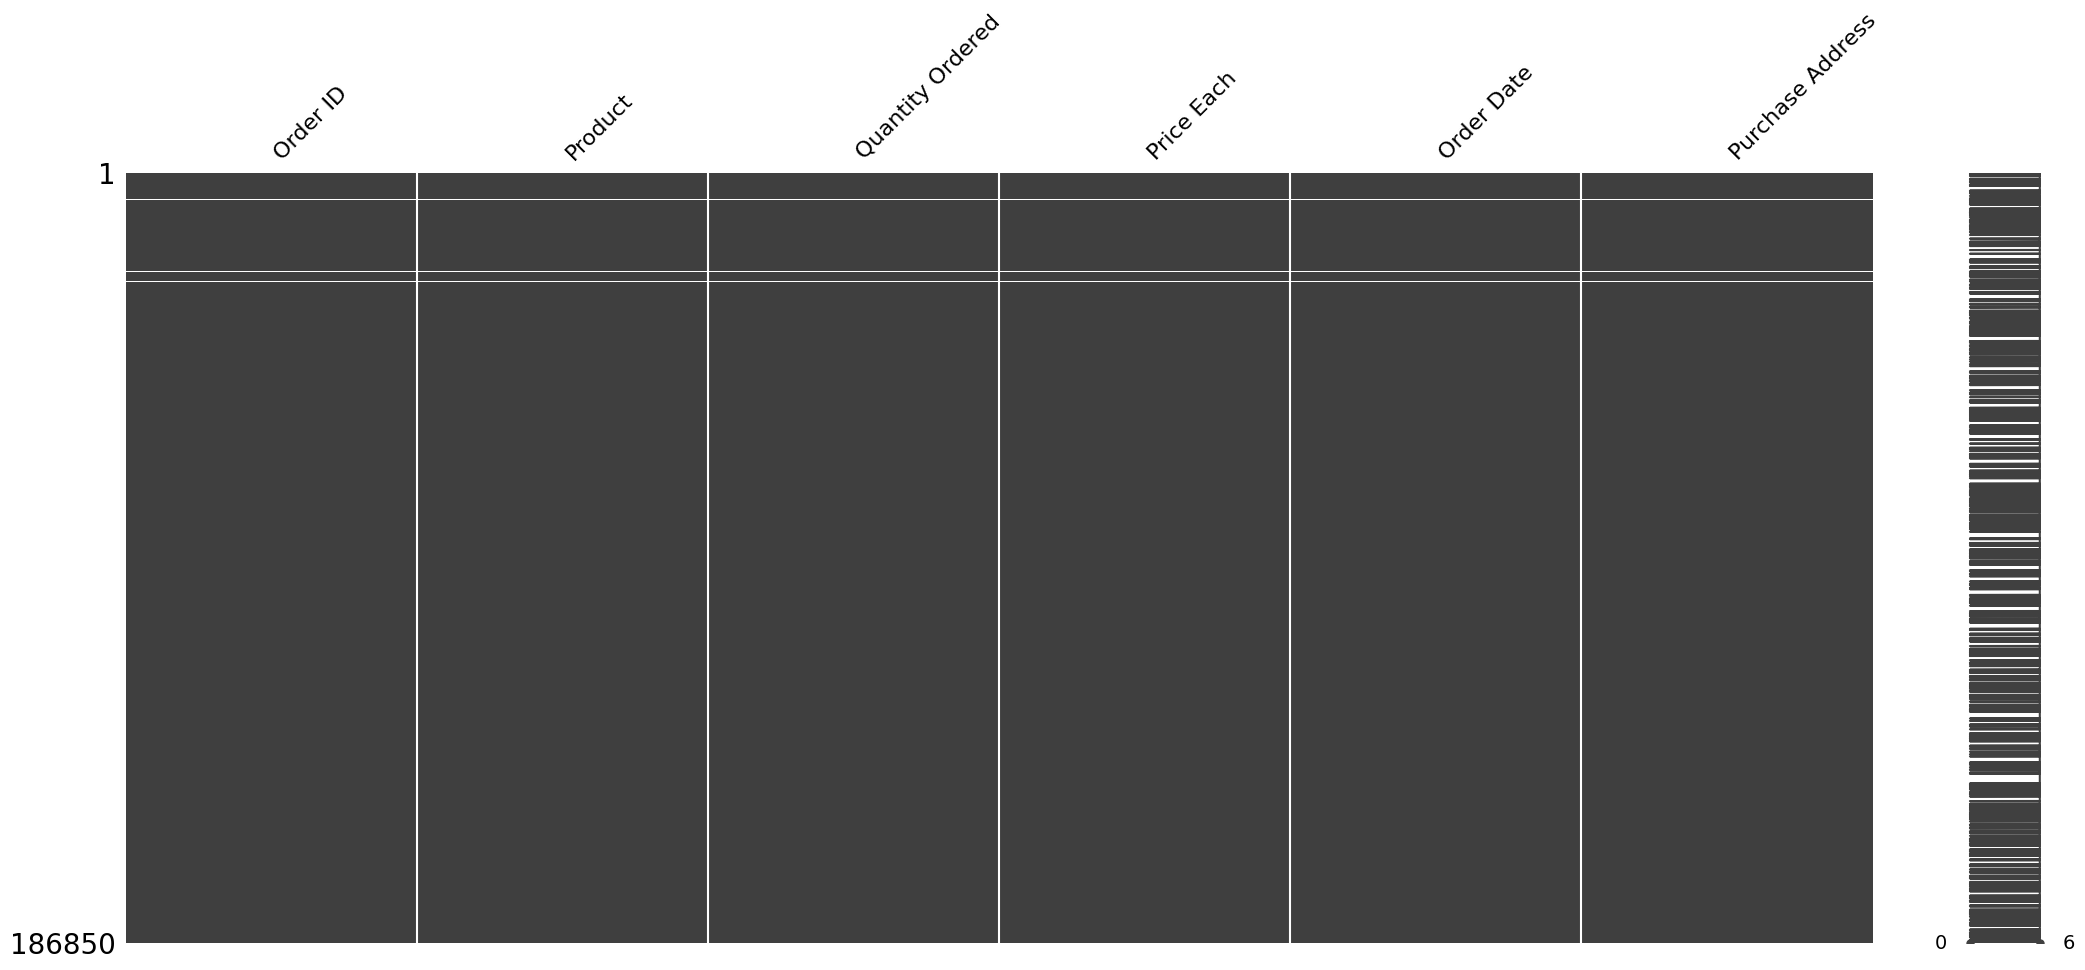

In [41]:
msno.matrix(all_data)

<Axes: >

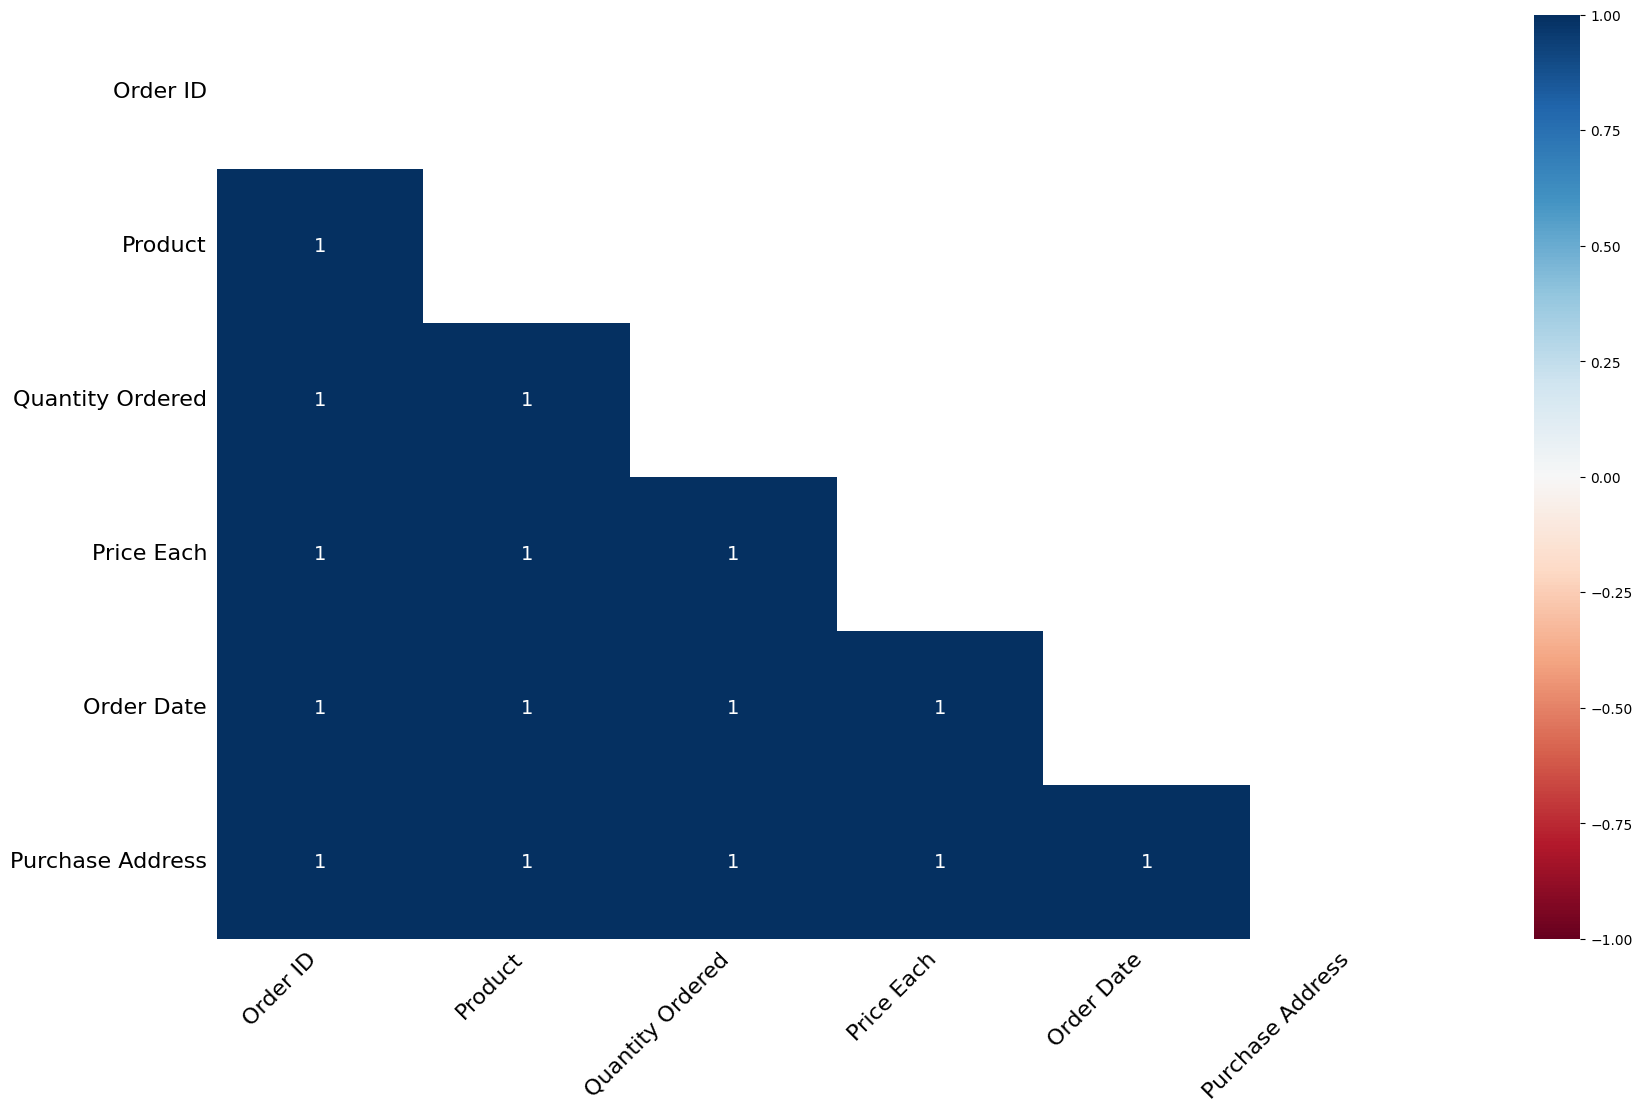

In [19]:
msno.heatmap(all_data)

The heatmap shows that when any attribute is missing, they all are, i.e. confirming that entire rows are missing

This step will be crucial in aiding the decision for which ML model to use

#### Example with a pattern in the missing data

Sometimes the data that is missing from a dataset is missing for a reason.\
This type of data is reliably missing based on the value of another variable in the dataset.

We can simulate a pattern, for example, by removing all values from 'Product' if it was ordered within the 11:00pm hour (22:00) and if the 'Purchase Address' contains '999'.

In [20]:
example = all_data.copy()

We will prematurely remove empty values from a copited dataset so we do not interfere with the rest of this project, as well as change the DType of 'Order Date' and 'Price Each'

To simulate a pattern we can:

(a) find all rows which contain "22:" in the 'Order Date' column and replace the 'Product' with None\
(b) find all rows which contain '99' in the 'Purchase Address' column and replace 'Price Each' with None

In [21]:
example.dropna(how='any', inplace=True)

In [22]:
# Find order dates at 22:00
result = example['Order Date'].str.contains("22:")
example_date = example[result]
example_date.head(3)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
48,176601,USB-C Charging Cable,1,11.95,04/02/19 22:32,"754 10th St, Los Angeles, CA 90001"
87,176640,Wired Headphones,2,11.99,04/27/19 22:54,"164 Lake St, San Francisco, CA 94016"


In [23]:
result = example['Purchase Address'].str.contains("9")
example_address = example[result]
example_address.head(3)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


In [24]:
print("22:00 in the Order Date:", len(example_date))
print("'999' in the Address     ", len(example_address))

22:00 in the Order Date: 8822
'999' in the Address      124008


What we should expect the see **2** relationships:
1. Strong relationship between 'Order Date' and 'Product'
2. Mild relationship between 'Address' and 'Price Each'



In [25]:
# Replace the rows in the copied dataset with None if they are part of the filtered DataFrame
example.loc[example_date["Product"].index, "Product"] = None
example.loc[example_address["Price Each"].index, "Price Each"] = None

We can check a few of the rows that contain '22:' to see if the changes were applied: `example.loc[[2, 48, 87]]`

##### Using a dendrogram to find a pattern

<Axes: >

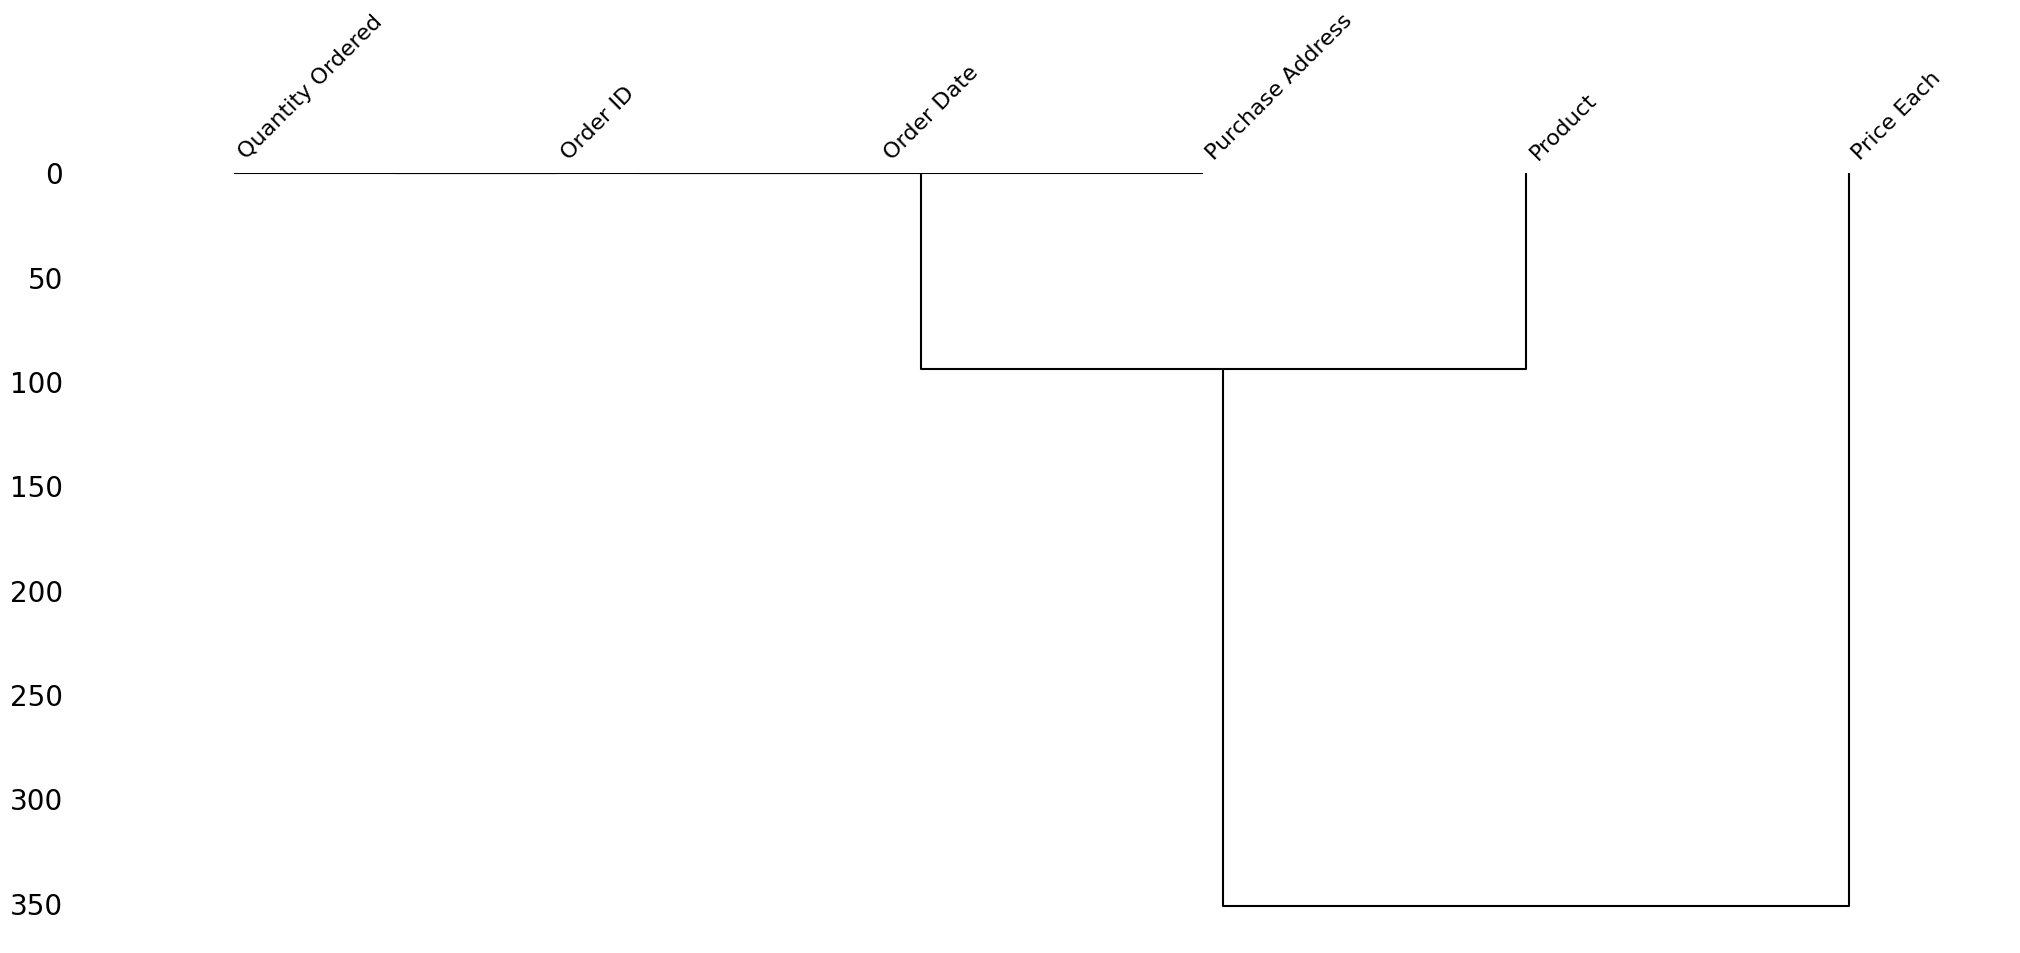

In [26]:
msno.dendrogram(example)

In this particular case, a dendrogram provides a sufficient way to visualize a relationship in the missing data. As we can see, missing data from 'Product' relats to 'Order Date' as expected. _See this [document](https://wheatoncollege.edu/wp-content/uploads/2012/08/How-to-Read-a-Dendrogram-Web-Ready.pdf) to learn how to read dendrograms._

### Clean it up!

Now that we have a better grasp of what data is missing and how much of it, we can move forward with what to _do_ with it

Since we are only dealing with 545 rows with NaN values, a small percentage of the total, we will remove the rows entirely.

In [42]:
# Drop these rows with missing data
all_data.dropna(how='any', inplace=True)

In [43]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186305 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 9.9+ MB


We can see that the number of non-null values (186305) is the same as the number of rows/entires

In [44]:
all_data.isnull().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

### Remove the rows with header names mixed into the dataset

If we remember from earlier, when we performed a sort on the dataset, we found that multiple rows contained what looked like column headers. This probably happened during the creation of the individual monthly sales CSV files were created.

In [45]:
all_data = all_data[all_data["Order ID"] != "Order ID"]
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001"


Now that we have a cleaned dataset, we can start to perform some other actions without error.

### Converting the data types

#### Convert Order Date column to valid date type

In [56]:
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600.00,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001"


In [58]:
date_format = '%m-%d-%Y'
all_data["Order Date"] = pd.to_datetime(all_data["Order Date"])
all_data.head(1)

C:\Users\havok\AppData\Local\Temp\ipykernel_17388\2470041052.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_data["Order Date"] = pd.to_datetime(all_data["Order Date"])


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001"


#### Convert Price & Quantity Ordered column to valid number type

In [48]:
all_data["Price Each"] = pd.to_numeric(all_data["Price Each"])

In [49]:
all_data["Quantity Ordered"] = pd.to_numeric(all_data["Quantity Ordered"])

#### Verify the data type changes

In [59]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185950 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185950 non-null  object        
 1   Product           185950 non-null  object        
 2   Quantity Ordered  185950 non-null  int64         
 3   Price Each        185950 non-null  float64       
 4   Order Date        185950 non-null  datetime64[ns]
 5   Purchase Address  185950 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 9.9+ MB


# **I** - _Inspect & Improve The Data_

Explore the dataset using visualizations and summary statistics to gain insights into the data's characteristics, relationships, and patterns. Some of the processes in this step may overlap with the previous.


## Steps to in this process can include:


1. **Feature engineering**: Creating new features or extracting useful information from existing ones to improve model performance.
2. **Data Summary and Statistics**: Obtain an overview of the dataset to check the data types, non-null counts, and summary statistics.
3. **Data Visualization**: Create visualizations, such as histograms, bar plots, box plots, and scatter plots, to understand the distribution of individual features and their relationships.
4. **Correlation Analysis**: Use a correlation matrix or heatmap to identify relationships between numerical attributes and determine which features are strongly or weakly correlated.

## Creating new features (feature engineering)

### Adding month, day, year column

In [60]:
all_data["Month"] = pd.to_datetime(all_data["Order Date"]).dt.month
all_data["Day"] = pd.to_datetime(all_data["Order Date"]).dt.day
all_data["Year"] = pd.to_datetime(all_data["Order Date"]).dt.year
all_data.head()


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Day,Year
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,19,2019
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,7,2019
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,12,2019
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,12,2019
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,30,2019


### Add Zip Code column

Since we are working with a large dataset there will be identical city names from different states.\
The safer way to identify cities is to use the zip code which is unique to every city in the U.S.

In [61]:
# We will need to iterate over each 'purhcase address' and extract the zip code
# Since the short version standard for zip codes is 5 digits, we can select the last 5 characters from the
# Purchase Address column

all_data["Zip"] = all_data["Purchase Address"].apply(lambda x: x[-5:])
all_data.head()


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Day,Year,Zip
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,19,2019,75001
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,7,2019,02215
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,12,2019,90001
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,12,2019,90001
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,30,2019,90001


### Add City/State column

In [163]:
all_data["City"] = all_data["Purchase Address"].apply(lambda x: x.split(",")[-2].strip(" "))
all_data["State"] = all_data["Purchase Address"].apply(lambda x: x.split(" ")[-2].split(" ")[0])
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Day,Year,Zip,City,State
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,19,2019,75001,Dallas,TX
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,7,2019,02215,Boston,MA
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,12,2019,90001,Los Angeles,CA
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,12,2019,90001,Los Angeles,CA
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,30,2019,90001,Los Angeles,CA


## Inspect and Explore

### What was the best month for sales? How much was earned that month? 

In [164]:
sales_order_data = (all_data.groupby(["Month"])                   
                   .agg({'Quantity Ordered': 'sum', 'Price Each': 'sum'})
                   .rename(columns={'Quantity Ordered': 'Orders', 'Price Each': 'Avg. Price'})
                   .reset_index())

In [63]:
sales_order_data

,Month,Orders,Avg. Price
0,1,10903,1811768.38
1,2,13449,2188884.72
2,3,17005,2791207.83
3,4,20558,3367671.02
4,5,18667,3135125.13
5,6,15253,2562025.61
6,7,16072,2632539.56
7,8,13448,2230345.42
8,9,13109,2084992.09
9,10,22703,3715554.83


In [64]:
months = range(1,13)


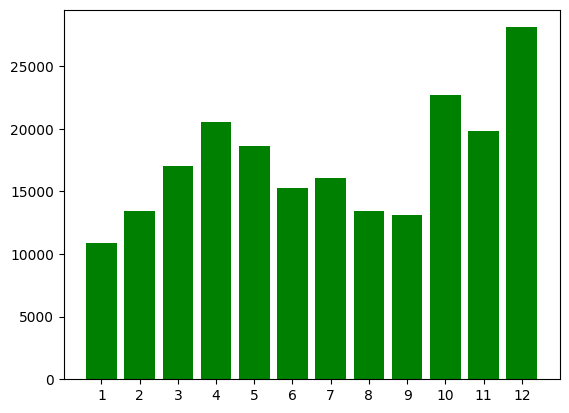

In [65]:
plt.bar(sales_order_data["Month"], sales_order_data["Orders"], color="green")
plt.xticks(months)
plt.show()

### What city sold the most product?

Before we begin working with City data, let's associate each zip code to it's appropriate city. This way we can use the city names instead of zip codes when helpful.

* First we can extract a Series of unique "Zip" codes from the _all_data_ DataFrame and then **merge** it with a subset of the main dataset _all_data_ containing only the "Zip" and "City" columns.
* The **merge** operation ensures that each "Zip" code in the final DataFrame appears only once, and the associated "City" names are matched correctly.
* The resulting DataFrame, `zips_to_city`, is sorted in ascending order based on the "Zip" codes.

In [170]:
zips = all_data["Zip"].drop_duplicates()
zips_to_city = all_data[["Zip", "City", "State"]].drop_duplicates().merge(zips, on="Zip").sort_values("Zip")
zips_to_city

,Zip,City,State
1,02215,Boston,MA
9,04101,Portland,ME
6,10001,New York City,NY
5,30301,Atlanta,GA
8,73301,Austin,TX
0,75001,Dallas,TX
2,90001,Los Angeles,CA
3,94016,San Francisco,CA
7,97035,Portland,OR
4,98101,Seattle,WA


In [171]:
sales_city_data = all_data.groupby(["Zip"], as_index=False)["Quantity Ordered"].sum()
sales_city_data

,Zip,Quantity Ordered
0,02215,22528
1,04101,2750
2,10001,27932
3,30301,16602
4,73301,11153
5,75001,16730
6,90001,33289
7,94016,50239
8,97035,11303
9,98101,16553


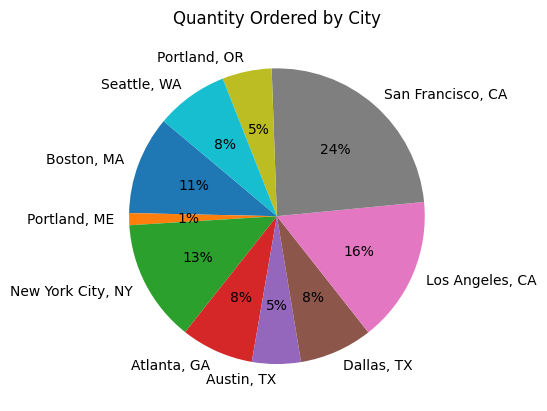

In [249]:
# Set the labels and sizes for the pie chart
labels = zips_to_city["City"] + ", " + zips_to_city["State"]
sizes = sales_city_data['Quantity Ordered']

plt.pie(sizes, labels=labels, autopct='%1.0f%%', startangle=140)

plt.title('Quantity Ordered by City')

plt.show()

#### Modify the the pie chart to add emphasis on important statistics

We can make the chart more visually appealing by "popping out" certain wedges.
This will allow us to emphasize certain statistics such as, the maximum or minimum orders of all cities.

In [251]:
# Get the index of the rows with highest and lowest value in "quantity ordered"
most_orders = sales_city_data["Quantity Ordered"].idxmax()
least_orders = sales_city_data["Quantity Ordered"].idxmin()

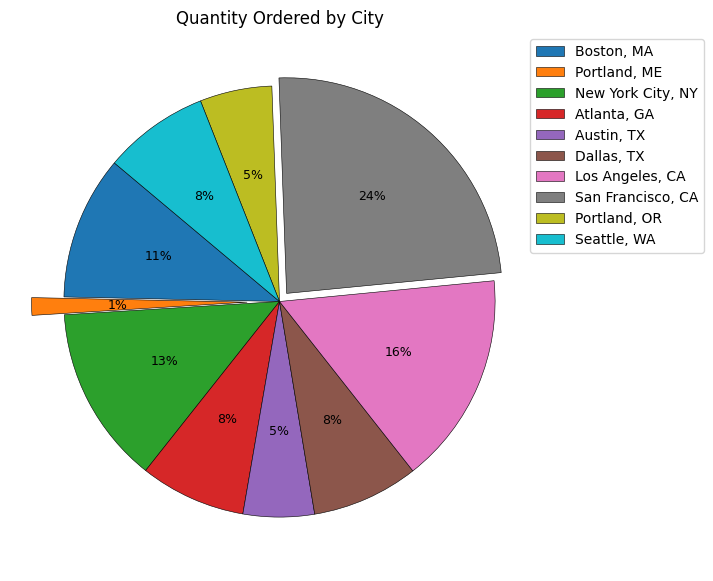

In [304]:
# Set the labels and sizes for the pie chart
fig, ax = plt.subplots(figsize=(7,7))

labels = zips_to_city["City"] + ", " + zips_to_city["State"]
sizes = sales_city_data['Quantity Ordered']

# The explode parameter takes in a list of percentages, with len(wedges)
explode = np.zeros(len(sizes))
explode[least_orders] = 0.15 # Explode the 2nd wedge by 20%
explode[most_orders] = 0.05 # Explode the 7th wedge by 5%

# Set the wedge properties to include the edge color
wedge_properties = {'edgecolor': 'black', 'linewidth': 0.4}

ax.pie(sizes, autopct='%1.0f%%', startangle=140, 
       explode=explode, wedgeprops=wedge_properties, textprops={'fontsize': 9})

ax.legend(labels, bbox_to_anchor=(1.3, 1))

plt.title('Quantity Ordered by City')

plt.show()

### When would be the best time of day to display advertisements?

In [306]:
# Add hour & minute column
all_data['Hour'] = pd.to_datetime(all_data['Order Date']).dt.hour
all_data['Minute'] = pd.to_datetime(all_data['Order Date']).dt.minute

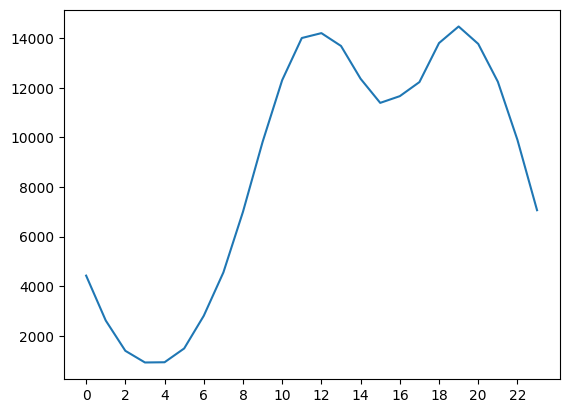

In [322]:
orders_by_hour = all_data.groupby(['Hour'])["Quantity Ordered"].sum()

plt.xticks(range(0, 24, 2))

plt.plot(orders_by_hour)

### What products are most often sold together?

There are X steps to answering this:

1. Find all Order IDs that have multiple, separate orders
2. Group the Order IDs and combine each related purchased product into a single list
3. Concatenate the product column containing the joined products per order with the DataFraem containing duplicate Order IDs

#### Find Order IDs that have multiple orders

In [384]:
dup_orders = all_data[all_data['Order ID'].duplicated(keep=False)]

#### Group Order IDs and combine products

In [414]:
prods_per_order = dup_orders.groupby("Order ID")["Product"].transform(lambda x: ', '.join(x))

##### Breakdown of how the `transform()` method works with the _lambda_ function

When you perform `.groupby("Order ID")["Product"].transform(...)`, the **transform()** method applies the provided function (the lambda function `lambda x: ','.join(x)`) to each group separately, and x takes on the values of the "Product" _column_ within that specific group.

When you apply the **transform()** method with the lambda function `lambda x: ','.join(x)`, here's what happens:

1. For the first group with "Order ID" 176560, x will be the list ['Google Phone', 'Wired Headphones'].
2. For the second group with "Order ID" 176574, x will be the list ['Google Phone', 'USB-C Charging Cable'].
3. and so on...

The lambda function `lambda x: ', '.join(x)` then joins these lists into a single string for each group:

1. For the first group with "Order ID" 176560, the output will be 'Google Phone, Wired Headphones'
2. For the second group with "Order ID" 176574, the output will be 'Google Phone, USB-C Charging Cable'


The **transform()** method applies this transformation to all rows within each group, so the resulting Series has the concatenated "Product" values for each "Order ID" group, and it has the same length as the original DataFrame.

#### Concatenate the product column duplicate Order IDs table

In [407]:
prods_per_order = pd.concat([dup_orders["Order ID"], prods_per_order], axis=1)
prods_per_order.head()

,Order ID,Product
3,176560,"Google Phone, Wired Headphones"
4,176560,"Google Phone, Wired Headphones"
18,176574,"Google Phone, USB-C Charging Cable"
19,176574,"Google Phone, USB-C Charging Cable"
30,176585,"Bose SoundSport Headphones, Bose SoundSport He..."


Now we have a table with a Product column that contains the all the products purchased from an individual order in one row

We can now sort count the number of instances of each product 'list' per order:

In [408]:
ordered_together = prods_per_order.groupby("Product").size().reset_index(name="Count").sort_values("Count", ascending=False)
ordered_together.head(3)

,Product,Count
342,"iPhone, Lightning Charging Cable",1764
173,"Google Phone, USB-C Charging Cable",1712
363,"iPhone, Wired Headphones",722


The conclusion is that the products most often sold together are the **iPhone** and the **Lightning Charging Cable**.\
In other words, an iPhone and Lightning Charging Cable were purchased together 1,754 times.

#### What product sold the most?

In [563]:
product_orders = (all_data.groupby("Product")["Quantity Ordered"]
                            .sum()
                            .reset_index(name="Amount Sold")
                            .sort_values("Product"))

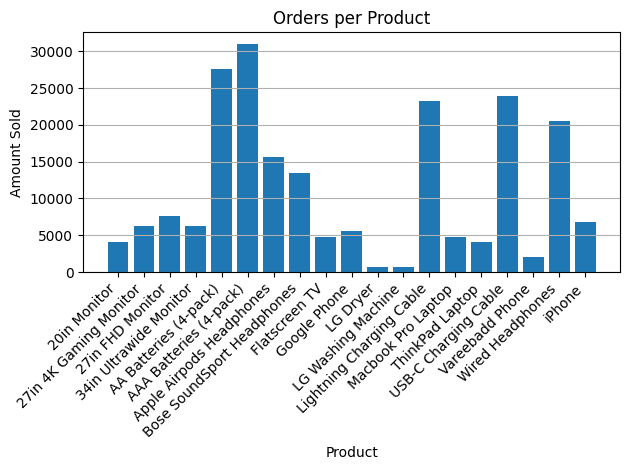

In [572]:
# Extract the "Product" and "Sales" columns
X = product_orders["Product"]
y = product_orders["Amount Sold"]

# Create the bar chart with custom X-axis labels
plt.bar(X, y)

# Customize the plot
plt.xlabel("Product")
plt.ylabel("Amount Sold")
plt.title("Orders per Product")
plt.grid(axis="y")

# Rotate the X-axis labels for better readability (rotate and align)
plt.xticks(rotation=45, ha='right')  # ha='right' adjusts alignment to prevent overlap

plt.tight_layout()  # ensure labels and titles are visible
plt.show()

In [530]:

product_mean_price = all_data.groupby("Product")['Price Each'].mean().reset_index(name="Mean Price")

In [531]:
product_orders = product_orders.sort_values("Product")
product_mean_price = product_mean_price.sort_values("Product")

C:\Users\havok\AppData\Local\Temp\ipykernel_17388\257624693.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(product_mean_price["Product"], rotation='vertical', size=8)
C:\Users\havok\AppData\Local\Temp\ipykernel_17388\257624693.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


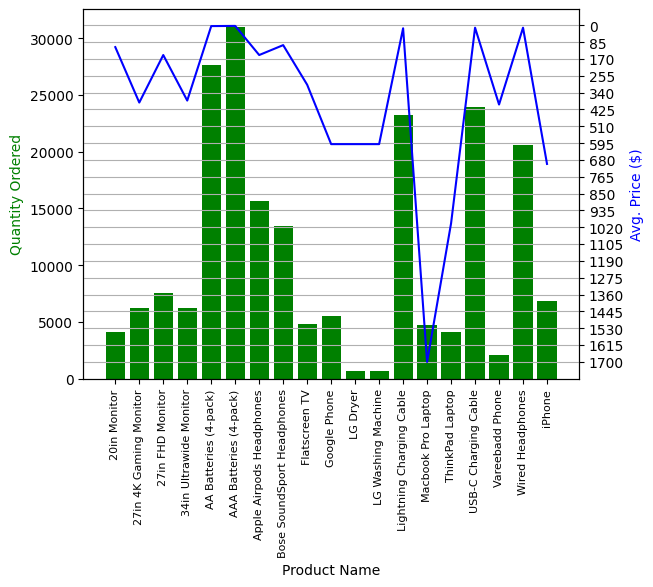

In [533]:
fig, ax1 = plt.subplots()

product_orders = product_orders.sort_values("Product")
product_count = product_mean_price.sort_values("Product")

X1 = product_orders["Product"]
y1 = product_orders["Amount Sold"]

X2 = product_mean_price["Product"]
y2 = product_mean_price["Mean Price"]


ax2 = ax1.twinx()
ax1.bar(X1, y1, color='g')
ax2.plot(X2, y2, color='b')

ax1.set_xlabel('Product Name')
ax1.set_ylabel('Quantity Ordered', color='g')
ax2.set_ylabel('Avg. Price ($)', color='b')

ax2.set_yticks(np.arange(0, max(y2) + 0.05 * max(y2), 0.05 * max(y2)))

ax2.set_ylim(ax2.get_ylim()[::-1])  # Invert the Y-axis limits

ax1.set_xticklabels(product_mean_price["Product"], rotation='vertical', size=8)

plt.grid(axis="y")

fig.show()

### Get insights on correlations